# Classify vehicles on emergency or non-emergency

In [4]:
# importing the libraries
import pandas as pd
import numpy as np
from tqdm import tqdm

# for reading and displaying images
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

# torchvision for pre-trained models
from torchvision import models

In [5]:
!unzip /content/emergency_vs_non-emergency_dataset.zip

Archive:  /content/emergency_vs_non-emergency_dataset.zip
   creating: emergency_vs_non-emergency_dataset/
  inflating: emergency_vs_non-emergency_dataset/emergency_train.csv  
   creating: emergency_vs_non-emergency_dataset/images/
  inflating: emergency_vs_non-emergency_dataset/images/1265.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/1260.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/1259.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/1256.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/1255.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/125.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/1249.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/1247.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/1245.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/1243.jpg  
  inflating: emergency_vs_non-emergency_dataset/images/1242.jpg  
  inflating: emergency_vs_non-emergency_da

In [6]:
# loading dataset
train = pd.read_csv('/content/emergency_vs_non-emergency_dataset/emergency_train.csv')
train.head()

,image_names,emergency_or_not
0,1503.jpg,0
1,1420.jpg,0
2,1764.jpg,0
3,1356.jpg,0
4,1117.jpg,0


There are two columns in the .csv file:

1.   image_names: It represents the name of all the images in the dataset
2.   emergency_or_no: It specifies whether that particular image belongs to the emergency or non-emergency class. 0 means that the image is a non-emergency vehicle and 1 represents an emergency vehicle

# Image Processing

There are 1,646 images in the dataset and they have been reshaped to (224,224,3) since VGG16 requires all the images in this particular shape. Let’s now visualize a few images from the dataset:

In [7]:
# loading training images
train_img = []
for img_name in tqdm(train['image_names']):
    # defining the image path
    image_path = '/content/emergency_vs_non-emergency_dataset/images/' + img_name
    # reading the image
    img = imread(image_path)
    # normalizing the pixel values
    img = img/255
    # print(img.shape)
    # resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

# converting the list to numpy array
train_x = np.array(train_img)
train_x.shape

100%|██████████| 1646/1646 [00:15<00:00, 107.04it/s]


(1646, 224, 224, 3)

It is an Emergency vehicle


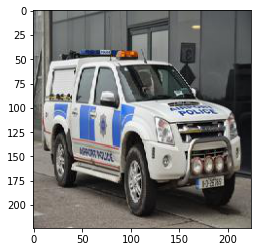

In [8]:
# Exploring the data
index = 10
plt.imshow(train_x[index])
if (train['emergency_or_not'][index] == 1):
    print('It is an Emergency vehicle')
else:
    print('It is a Non-Emergency vehicle')

This is a police car and hence has a label of Emergency vehicle. Now store the target in a separate variable:

In [9]:
# defining the target
train_y = train['emergency_or_not'].values

In [10]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, random_state = 13, stratify=train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((1481, 224, 224, 3), (1481,)), ((165, 224, 224, 3), (165,)))

1,481 images in the training set and remaining 165 images in the validation set are converted into torch format:

In [11]:
# converting training images into torch format
train_x = train_x.reshape(1481, 3, 224, 224)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([1481, 3, 224, 224]), torch.Size([1481]))

In [12]:
# converting validation images into torch format
val_x = val_x.reshape(165, 3, 224, 224)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([165, 3, 224, 224]), torch.Size([165]))

# Vanilla CNN

Usually used as a benchmark

In [13]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(8 * 56 * 56, 2)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [14]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=25088, out_features=2, bias=True)
  )
)


In [15]:
# batch size of the model
batch_size = 128

# number of epochs to train the model
n_epochs = 15

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
        
    permutation = torch.randperm(train_x.size()[0])

    training_loss = []
    for i in tqdm(range(0,train_x.size()[0], batch_size)):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = train_x[indices], train_y[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        # in case you wanted a semi-full example
        outputs = model(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

 17%|█▋        | 2/12 [00:00<00:00, 19.26it/s]

epoch: 	 1 	 training loss: 	 0.8101396163304647


 17%|█▋        | 2/12 [00:00<00:00, 19.20it/s]

epoch: 	 2 	 training loss: 	 0.6502994944651922


 17%|█▋        | 2/12 [00:00<00:00, 19.07it/s]

epoch: 	 3 	 training loss: 	 0.6039342532555262


 17%|█▋        | 2/12 [00:00<00:00, 19.17it/s]

epoch: 	 4 	 training loss: 	 0.5880758116642634


 17%|█▋        | 2/12 [00:00<00:00, 19.44it/s]

epoch: 	 5 	 training loss: 	 0.5575701668858528


 17%|█▋        | 2/12 [00:00<00:00, 19.20it/s]

epoch: 	 6 	 training loss: 	 0.539302279551824


 17%|█▋        | 2/12 [00:00<00:00, 18.90it/s]

epoch: 	 7 	 training loss: 	 0.5262438108523687


 17%|█▋        | 2/12 [00:00<00:00, 19.05it/s]

epoch: 	 8 	 training loss: 	 0.5014186675349871


 17%|█▋        | 2/12 [00:00<00:00, 18.48it/s]

epoch: 	 9 	 training loss: 	 0.4785558332999547


 17%|█▋        | 2/12 [00:00<00:00, 18.91it/s]

epoch: 	 10 	 training loss: 	 0.46593211591243744


 17%|█▋        | 2/12 [00:00<00:00, 19.17it/s]

epoch: 	 11 	 training loss: 	 0.44710880517959595


 17%|█▋        | 2/12 [00:00<00:00, 19.16it/s]

epoch: 	 12 	 training loss: 	 0.4318452949325244


 17%|█▋        | 2/12 [00:00<00:00, 19.09it/s]

epoch: 	 13 	 training loss: 	 0.4182896812756856


 17%|█▋        | 2/12 [00:00<00:00, 19.42it/s]

epoch: 	 14 	 training loss: 	 0.4100518450140953


100%|██████████| 12/12 [00:00<00:00, 18.28it/s]

epoch: 	 15 	 training loss: 	 0.3807670896251996


In [16]:
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(train_x.size()[0])
for i in tqdm(range(0,train_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = train_x[indices], train_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu().data.numpy(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 12/12 [00:00<00:00, 22.71it/s]

training accuracy: 	 0.8792094748858448


We got a training accuracy of around 87% which is a good score. Let’s now check the validation accuracy:

In [17]:
# prediction for validation set
prediction_val = []
target_val = []
permutation = torch.randperm(val_x.size()[0])
for i in tqdm(range(0,val_x.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = val_x[indices], val_y[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_val.append(predictions)
    target_val.append(batch_y)
    
# validation accuracy
accuracy_val = []
for i in range(len(prediction_val)):
    accuracy_val.append(accuracy_score(target_val[i].cpu().data.numpy(),prediction_val[i]))
    
print('validation accuracy: \t', np.average(accuracy_val))

100%|██████████| 2/2 [00:00<00:00, 33.40it/s]

validation accuracy: 	 0.7125211148648649


The validation accuracy comes out to be 70% which pales in comparison. This serves as a benchmark. Next, use transfer learning to solve this problem. 

# Transfer Learning

The steps to train the model using transfer learning:

1.   First, we will load the weights of the pre-trained model – VGG16 in our case
2.   Then we will fine tune the model as per the problem at hand
3.   Next, we will use these pre-trained weights and extract features for our images
4.   Finally, we will train the fine tuned model using the extracted features



In [18]:
# loading the pretrained model
model = models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [19]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

There are 2 classes to predict and VGG16 is trained on ImageNet which has 1000 classes, there is a need to update the final layer as per the specific problem.

In [20]:
# Add on classifier
model.classifier[6] = Sequential(
                      Linear(4096, 2))
for param in model.classifier[6].parameters():
    param.requires_grad = True

To train the last layer, the requires_grad for the layer have to be set as True. Let’s set the training to GPU.

Let’s set the training to GPU.

In [21]:
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [22]:
# batch_size
batch_size = 128

# extracting features for train data
data_x = []
label_x = []

inputs,labels = train_x, train_y

for i in tqdm(range(int(train_x.shape[0]/batch_size)+1)):
    input_data = inputs[i*batch_size:(i+1)*batch_size]
    label_data = labels[i*batch_size:(i+1)*batch_size]
    input_data , label_data = Variable(input_data.cuda()),Variable(label_data.cuda())
    x = model.features(input_data.cuda())
    data_x.extend(x.data.cpu().numpy())
    label_x.extend(label_data.data.cpu().numpy())

100%|██████████| 12/12 [00:07<00:00,  1.69it/s]


In [23]:
# extracting features for validation data
data_y = []
label_y = []

inputs,labels = val_x, val_y

for i in tqdm(range(int(val_x.shape[0]/batch_size)+1)):
    input_data = inputs[i*batch_size:(i+1)*batch_size]
    label_data = labels[i*batch_size:(i+1)*batch_size]
    input_data , label_data = Variable(input_data.cuda()),Variable(label_data.cuda())
    x = model.features(input_data.cuda())
    data_y.extend(x.data.cpu().numpy())
    label_y.extend(label_data.data.cpu().numpy())

100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


In [24]:
# converting the features into torch format
x_train  = torch.from_numpy(np.array(data_x))
x_train = x_train.view(x_train.size(0), -1)
y_train  = torch.from_numpy(np.array(label_x))
x_val  = torch.from_numpy(np.array(data_y))
x_val = x_val.view(x_val.size(0), -1)
y_val  = torch.from_numpy(np.array(label_y))

In [25]:
import torch.optim as optim

# specify loss function
criterion = CrossEntropyLoss()

# specify optimizer and learning rate
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.0005)

In [26]:
# batch size
batch_size = 128

# number of epochs to train the model
n_epochs = 30

for epoch in tqdm(range(1, n_epochs+1)):

    # keep track of training and validation loss
    train_loss = 0.0
        
    permutation = torch.randperm(x_train.size()[0])

    training_loss = []
    for i in range(0,x_train.size()[0], batch_size):

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        if torch.cuda.is_available():
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        
        optimizer.zero_grad()
        # in case you wanted a semi-full example
        outputs = model.classifier(batch_x)
        loss = criterion(outputs,batch_y)

        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    training_loss = np.average(training_loss)
    print('epoch: \t', epoch, '\t training loss: \t', training_loss)

  7%|▋         | 2/30 [00:00<00:04,  6.09it/s]

epoch: 	 1 	 training loss: 	 0.634782001376152
epoch: 	 2 	 training loss: 	 0.5196206942200661


 13%|█▎        | 4/30 [00:00<00:04,  6.08it/s]

epoch: 	 3 	 training loss: 	 0.47351022561391193
epoch: 	 4 	 training loss: 	 0.453992818792661


 20%|██        | 6/30 [00:00<00:03,  6.12it/s]

epoch: 	 5 	 training loss: 	 0.436656358341376
epoch: 	 6 	 training loss: 	 0.4325019096334775


 27%|██▋       | 8/30 [00:01<00:03,  6.14it/s]

epoch: 	 7 	 training loss: 	 0.42470891028642654
epoch: 	 8 	 training loss: 	 0.4138946359356244


 33%|███▎      | 10/30 [00:01<00:03,  6.05it/s]

epoch: 	 9 	 training loss: 	 0.4068816229701042
epoch: 	 10 	 training loss: 	 0.39944549401601154


 40%|████      | 12/30 [00:01<00:02,  6.13it/s]

epoch: 	 11 	 training loss: 	 0.398816242814064
epoch: 	 12 	 training loss: 	 0.39193615317344666


 47%|████▋     | 14/30 [00:02<00:02,  6.12it/s]

epoch: 	 13 	 training loss: 	 0.39300836126009625
epoch: 	 14 	 training loss: 	 0.3807535544037819


 53%|█████▎    | 16/30 [00:02<00:02,  6.08it/s]

epoch: 	 15 	 training loss: 	 0.3876273309191068
epoch: 	 16 	 training loss: 	 0.365109587709109


 60%|██████    | 18/30 [00:02<00:01,  6.08it/s]

epoch: 	 17 	 training loss: 	 0.38077934583028156
epoch: 	 18 	 training loss: 	 0.3648728628953298


 67%|██████▋   | 20/30 [00:03<00:01,  6.13it/s]

epoch: 	 19 	 training loss: 	 0.37697024643421173
epoch: 	 20 	 training loss: 	 0.37384723375240964


 73%|███████▎  | 22/30 [00:03<00:01,  6.14it/s]

epoch: 	 21 	 training loss: 	 0.35718678931395215
epoch: 	 22 	 training loss: 	 0.365610308945179


 80%|████████  | 24/30 [00:03<00:00,  6.14it/s]

epoch: 	 23 	 training loss: 	 0.3694082275032997
epoch: 	 24 	 training loss: 	 0.3612728814284007


 87%|████████▋ | 26/30 [00:04<00:00,  6.12it/s]

epoch: 	 25 	 training loss: 	 0.3561461269855499
epoch: 	 26 	 training loss: 	 0.3564560264348984


 93%|█████████▎| 28/30 [00:04<00:00,  6.14it/s]

epoch: 	 27 	 training loss: 	 0.3482185825705528
epoch: 	 28 	 training loss: 	 0.3575662299990654


100%|██████████| 30/30 [00:04<00:00,  6.10it/s]

epoch: 	 29 	 training loss: 	 0.34120848526557285
epoch: 	 30 	 training loss: 	 0.3652077565590541


In [27]:
# prediction for training set
prediction = []
target = []
permutation = torch.randperm(x_train.size()[0])
for i in tqdm(range(0,x_train.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = x_train[indices], y_train[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model.classifier(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction.append(predictions)
    target.append(batch_y)
    
# training accuracy
accuracy = []
for i in range(len(prediction)):
    accuracy.append(accuracy_score(target[i].cpu().data.numpy(),prediction[i]))
    
print('training accuracy: \t', np.average(accuracy))

100%|██████████| 12/12 [00:00<00:00, 75.58it/s]


training accuracy: 	 0.8552903824200913


In [28]:
# prediction for validation set
prediction_val = []
target_val = []
permutation = torch.randperm(x_val.size()[0])
for i in tqdm(range(0,x_val.size()[0], batch_size)):
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = x_val[indices], y_val[indices]

    if torch.cuda.is_available():
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()

    with torch.no_grad():
        output = model.classifier(batch_x.cuda())

    softmax = torch.exp(output).cpu()
    prob = list(softmax.numpy())
    predictions = np.argmax(prob, axis=1)
    prediction_val.append(predictions)
    target_val.append(batch_y)
    
# validation accuracy
accuracy_val = []
for i in range(len(prediction_val)):
    accuracy_val.append(accuracy_score(target_val[i].cpu().data.numpy(),prediction_val[i]))
    
print('validation accuracy: \t', np.average(accuracy_val))

100%|██████████| 2/2 [00:00<00:00, 88.82it/s]

validation accuracy: 	 0.8017314189189189


Validation accuracy performed much better than vanilla CNN. Moreover, the training and validation accuracies for VGG16 is much in sync so the model is well generalized. 